# Multi-classification Assessment of Bank Personal Credit Risk Based on Multi-source Information Fusion

This notebook implements the methods described in the paper: 

"Multi-classification assessment of bank personal credit risk based on multi-source information fusion"

By Tianhui Wang, Renjing Liu, Guohua Qi

Reference: Expert Systems With Applications 191 (2022) 116236

# Introduction

The paper proposes a new multi-classification assessment model for personal credit risk based on the theory of information fusion (MIFCA) using six machine learning algorithms. The MIFCA model integrates the advantages of multiple classifiers and reduces the interference of uncertain information through Dempster-Shafer (D-S) evidence theory. The key contributions of the paper are:

- Constructing a new multi-classification credit assessment model to provide more accurate five-classification credit assessments compared to traditional binary classifications.

- Innovatively fusing six different types of classifiers using D-S evidence theory to reduce uncertainty and improve overall accuracy and robustness.

- Creating a model with fewer parameters to enhance efficiency and usability, suitable for big data applications

- Verifying the assessment performance of MIFCA on real datasets and comparing it with classic statistical and machine learning approaches.

# Objective

Our goal is to replicate the MIFCA model as described in the paper using the provided dataset. We will:

- Preprocess the data, handling missing values, outliers, and encoding categorical variables.

- Train six base classifiers: Decision Tree (DT), Random Forest (RF), Support Vector Machine (SVM), K-Nearest Neighbors (KNN), BP Neural Network (implemented as Multi-Layer Perceptron), and XGBoost.

- Implement Dempster-Shafer evidence theory to fuse the outputs of these classifiers.

- Evaluate the performance of the fused model and compare it with individual classifiers.

# Implementation

## Import Necessary Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing and model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Machine Learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# For Progress Bar
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ensure numpy arrays are contiguous
import numpy as np

# Check versions (optional)
import sklearn
print("Scikit-learn version:", sklearn.__version__)
import numpy
print("NumPy version:", numpy.__version__)

Scikit-learn version: 1.5.2
NumPy version: 2.0.1


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA tersedia. Model berjalan di GPU {torch.cuda.get_device_name(0)}.")
else:
    device = torch.device("cpu")
    print("CUDA tidak tersedia. Model berjalan di CPU.")

CUDA tersedia. Model berjalan di GPU NVIDIA GeForce RTX 3060 Laptop GPU.


## 1. Data Loading and Preprocessing

### 1.1 Load the Dataset

Assuming your dataset is in the data folder and named `Dataset-Research.xlsx`

In [4]:
# Load the dataset
data = pd.read_excel('data/Dataset-Research.xlsx', header=1)

# Display the first few rows
data.head()

,Customer ID,Type of Loan Business,Guarantee the Balance,Account Connection Amount,Security Guarantee Amount,Five-level Classification,Whether Interest is Owed,Whether Self-service Loan,Type of Guarantee,Safety Coefficient,...,Whether Interest is Owed (regulatory standard),Repayment Type,Installment Repayment Method (numerical type),Installment Repayment Method (discrete type),Installment Repayment Cycle (numerical type),Repayment Cycle (discrete type),Number of Houses,Month Property Costs,Family Monthly Income,Five Categories
0,1,Personal Housing Mortgage Loan (First hand),850000.00,850000.00,85000000.0,A1,N,N,General Enterprise Guarantee,100.0,...,N,Payment by installments,2.0,Equal repayment of principal,M01,Month,1.0,343.84,15000.00,Normal
1,2,Personal Housing Mortgage Loan (First hand),2143810.46,2143810.46,171504836.8,A1,N,N,Average house,80.0,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,1.0,342.55,19700.00,Normal
2,3,Personal Commercial Housing Mortgage Loan (Fir...,892500.00,892500.00,89250000.0,A1,N,N,General Enterprise Guarantee,100.0,...,N,Payment by installments,2.0,Equal repayment of principal,M01,Month,NaN,282.00,39678.00,Normal
3,4,Housing accumulation fund loan 3,NaN,NaN,NaN,A1,N,N,General Enterprise Guarantee,NaN,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,NaN,NaN,3490.00,Normal
4,5,Personal Commercial Housing Mortgage Loan (Fir...,606400.45,606400.45,60640045.0,A1,N,N,Average house,100.0,...,N,Payment by installments,1.0,Matching the principal and interest,M01,Month,NaN,NaN,51502.56,Normal


### 1.2 Data Cleaning and Handling Missing Values

In [5]:
# Drop irrelevant columns
columns_to_drop = [
    'Customer ID', 'Account Connection Amount', 'Security Guarantee Amount', 'Whether Interest is Owed',
    'Whether Self-service Loan', 'Type of Guarantee', 'Date Code', 'Repayment Type',
    'Installment Repayment Cycle (numerical type)', 'Repayment Cycle (discrete type)',
    'Industry Category', 'Whether Personal Business Loan', 'Installment Repayment Method (discrete type)'
]
data.drop(columns=columns_to_drop, inplace=True)

# Handle missing values in numerical columns
numerical_cols_with_na = ['Guarantee the Balance', 'Safety Coefficient', 'Collateral Value (yuan)', 
                          'Down Payment Amount', 'Number of Houses', 'Installment Repayment Method (numerical type)',
                          'Month Property Costs', 'Family Monthly Income']

imputer_num = SimpleImputer(strategy='mean')
data[numerical_cols_with_na] = imputer_num.fit_transform(data[numerical_cols_with_na])

# Handle missing values in categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')

# Ensure the correct reshaping of the result using `.ravel()` to avoid the ValueError
data['Guarantee Method'] = imputer_cat.fit_transform(data[['Guarantee Method']]).ravel()

### 1.3 Data Encoding and Transformation

In [6]:
# Label encoding for binary categorical variables
label_encoder = LabelEncoder()

# Binary variables
binary_vars = ['Whether Devalue Account', 'Whether Interest is Owed (regulatory standard)']
for var in binary_vars:
    data[var] = label_encoder.fit_transform(data[var])

# Encode target variable 'Five Categories'
data['Five Categories'] = label_encoder.fit_transform(data['Five Categories'])

# One-hot encoding for other categorical variables
data = pd.get_dummies(data, columns=['Type of Loan Business', 'Guarantee Method'], drop_first=True)

# Drop unnecessary columns
data.drop('Five-level Classification', axis=1, inplace=True)

# Separate features and target
X = data.drop('Five Categories', axis=1)
y = data['Five Categories']

### 1.4 Data Splitting and Handling Imbalanced Data with SMOTE

In [7]:
# Split into training and test sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### 1.5 Standardization of Numerical Features

In [8]:
# Standardize the numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train_resampled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

## 2. Model Training

### 2.1 Train Base Classifiers

In [9]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)
dt_probs = dt_model.predict_proba(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_probs = rf_model.predict_proba(X_test)

# Calibrated SVM for probability prediction
svm_model = LinearSVC(random_state=42, max_iter=5000)
calibrated_svm = CalibratedClassifierCV(svm_model, method='sigmoid')  # Calibrate using sigmoid
calibrated_svm.fit(X_train_resampled, y_train_resampled)
svm_probs = calibrated_svm.predict_proba(X_test)

# Train K-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_resampled, y_train_resampled)
knn_probs = knn_model.predict_proba(X_test)

# Train BP Neural Network (MLP)
bp_model = MLPClassifier(random_state=42, max_iter=300)
bp_model.fit(X_train_resampled, y_train_resampled)
bp_probs = bp_model.predict_proba(X_test)

# Train XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_probs = xgb_model.predict_proba(X_test)

## 3. Dempster-Shafer Evidence Theory Fusion

### 3.1 Defining the MassFunction Class

In [18]:
# Get unique classes and majority class from training data
classes = sorted(list(set(y_train)))
majority_class = y_train.mode()[0]

class MassFunction:
    def __init__(self, mass_dict):
        self.mass = {}
        total_mass = sum(mass_dict.values())
        for hypothesis, mass_value in mass_dict.items():
            if hypothesis == 'theta':
                hypothesis = frozenset(classes)
            else:
                hypothesis = frozenset([hypothesis])
            self.mass[hypothesis] = mass_value / total_mass

    def combine_dempster(self, other):
        """Implements Dempster's combination rule as described in the paper"""
        combined = {}
        conflict = 0
        
        # Calculate combined masses
        for h1, m1 in self.mass.items():
            for h2, m2 in other.mass.items():
                intersection = h1.intersection(h2)
                if intersection:
                    combined[intersection] = combined.get(intersection, 0) + m1 * m2
                else:
                    conflict += m1 * m2
                    
        # Normalize if not completely conflicting
        if conflict < 1:
            factor = 1.0 / (1.0 - conflict)
            normalized = {}
            for h, m in combined.items():
                # Handle single element sets and theta
                if len(h) == 1:
                    normalized[next(iter(h))] = m * factor
                else:
                    normalized['theta'] = m * factor
            return MassFunction(normalized)
        else:
            # Complete conflict - return majority class
            return MassFunction({majority_class: 1.0})
    
    def get_decision(self):
        """Returns class with maximum mass"""
        max_mass = 0
        decision = majority_class
        
        for h, m in self.mass.items():
            if isinstance(h, frozenset):
                if len(h) == 1 and m > max_mass:
                    max_mass = m
                    decision = next(iter(h))
            else:
                if m > max_mass:
                    max_mass = m
                    decision = h
        
        return decision

### 3.2 Implement Fusion Process

In [19]:
def create_mass_functions(probabilities):
    """Creates mass functions from classifier probabilities"""
    mass_functions = []
    
    for prob in probabilities:
        mass = {}
        # Assign 90% of mass to class probabilities and 10% to uncertainty
        for i, p in enumerate(prob):
            mass[i] = 0.9 * p
        mass['theta'] = 0.1  # Uncertainty mass
        mass_functions.append(MassFunction(mass))
        
    return mass_functions

def fuse_classifications(classifiers_probs):
    """Fuses multiple classifier outputs using D-S evidence theory"""
    n_samples = len(classifiers_probs[0])
    final_decisions = []
    
    # Process each sample
    for i in range(n_samples):
        # Get probabilities for current sample from all classifiers
        sample_probs = [clf_probs[i] for clf_probs in classifiers_probs]
        
        # Create mass functions for current sample
        mass_functions = []
        for prob in sample_probs:
            mass = {}
            for j, p in enumerate(prob):
                mass[j] = 0.9 * p
            mass['theta'] = 0.1
            mass_functions.append(MassFunction(mass))
        
        # Combine evidence
        combined = mass_functions[0]
        for j in range(1, len(mass_functions)):
            combined = combined.combine_dempster(mass_functions[j])
        
        # Get decision
        final_decisions.append(combined.get_decision())
    
    return np.array(final_decisions)

# Use the functions with our trained models
probabilities = [
    dt_probs,
    rf_probs, 
    svm_probs,
    knn_probs,
    bp_probs,
    xgb_probs
]

# Get fused predictions
fused_predictions = fuse_classifications(probabilities)

## 4. Model Evaluation

### 4.1 Evaluate Base Classifiers


Performance Metrics for Decision Tree:
Accuracy: 0.8977
Macro Precision: 0.6373
Macro Recall: 0.7465
Macro F1-Score: 0.6794

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.50      0.39        22
           1       0.90      0.94      0.92        70
           2       0.97      0.92      0.95      5104
           3       0.28      0.52      0.36       289
           4       0.71      0.85      0.77        20

    accuracy                           0.90      5505
   macro avg       0.64      0.75      0.68      5505
weighted avg       0.93      0.90      0.91      5505


Performance Metrics for Random Forest:
Accuracy: 0.9381
Macro Precision: 0.7512
Macro Recall: 0.7413
Macro F1-Score: 0.7446

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        22
           1       0.90      0.99      0.94        70
           2       0.97      0.9

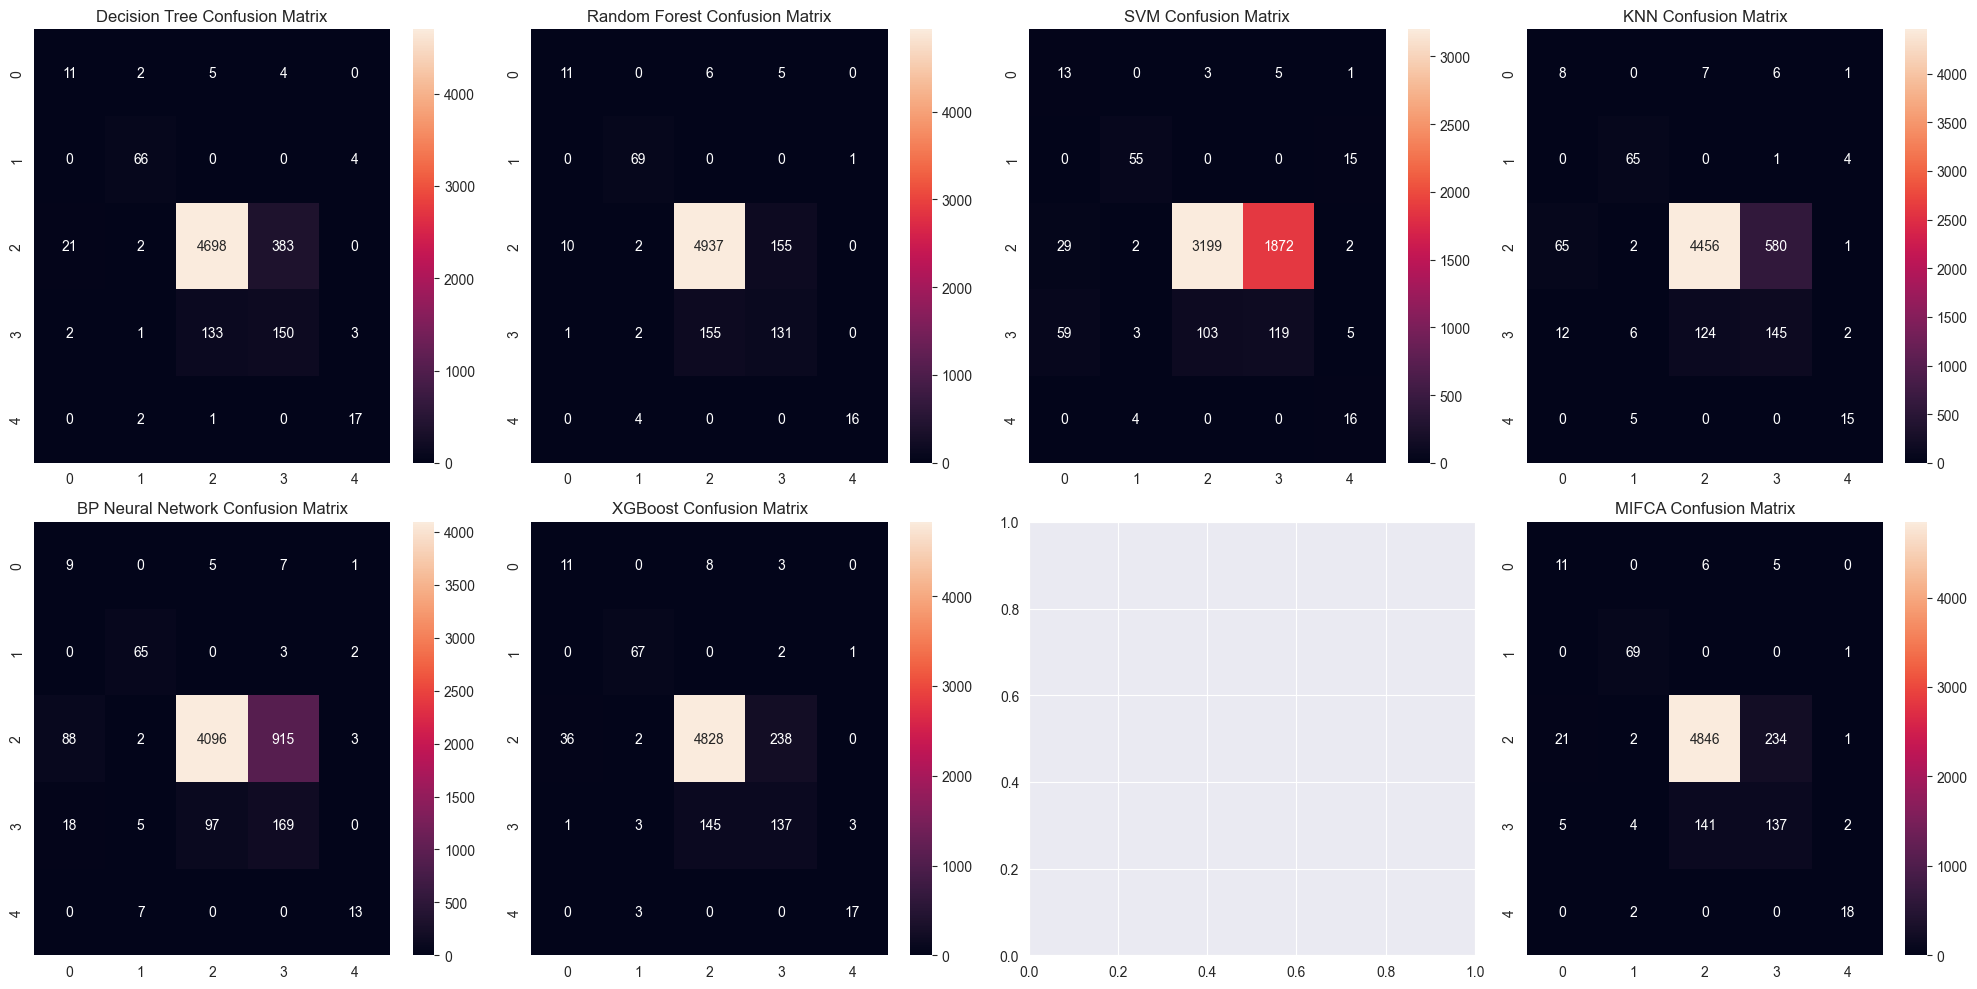

In [20]:
def evaluate_model(name, y_true, y_pred):
    """Evaluates model performance using metrics from the paper"""
    
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\nPerformance Metrics for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    return accuracy, precision_macro, recall_macro, f1_macro

# Get predictions from all base models
predictions = {
    'Decision Tree': dt_model.predict(X_test),
    'Random Forest': rf_model.predict(X_test),
    'SVM': calibrated_svm.predict(X_test),
    'KNN': knn_model.predict(X_test),
    'BP Neural Network': bp_model.predict(X_test),
    'XGBoost': xgb_model.predict(X_test)
}

# Get probabilities from all models
probabilities = [
    dt_model.predict_proba(X_test),
    rf_model.predict_proba(X_test),
    calibrated_svm.predict_proba(X_test),
    knn_model.predict_proba(X_test),
    bp_model.predict_proba(X_test),
    xgb_model.predict_proba(X_test)
]

# Fuse predictions using D-S evidence theory
fused_predictions = fuse_classifications(probabilities)

# Evaluate all models
results = {}
for name, pred in predictions.items():
    results[name] = evaluate_model(name, y_test, pred)

# Evaluate MIFCA
results['MIFCA'] = evaluate_model('MIFCA', y_test, fused_predictions)

# Plot confusion matrices
def plot_confusion_matrices(predictions, y_true):
    n_models = len(predictions) + 1  # +1 for MIFCA
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for idx, (name, pred) in enumerate(predictions.items()):
        cm = confusion_matrix(y_true, pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
        axes[idx].set_title(f'{name} Confusion Matrix')
        
    # Plot MIFCA confusion matrix
    cm = confusion_matrix(y_true, fused_predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[-1])
    axes[-1].set_title('MIFCA Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(predictions, y_test)

### 4.2 Evaluate the MIFCA Model

In [21]:
# Convert fused predictions to numpy array
fused_predictions_array = np.array(fused_predictions)

# Ensure data types match
if fused_predictions_array.dtype != y_test.dtype:
    fused_predictions_array = fused_predictions_array.astype(y_test.dtype)

# Evaluate the fused model
evaluate_model("MIFCA Model", y_test, fused_predictions_array)


Performance Metrics for MIFCA Model:
Accuracy: 0.9230
Macro Precision: 0.6693
Macro Recall: 0.7618
Macro F1-Score: 0.7081

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.50      0.37        22
           1       0.90      0.99      0.94        70
           2       0.97      0.95      0.96      5104
           3       0.36      0.47      0.41       289
           4       0.82      0.90      0.86        20

    accuracy                           0.92      5505
   macro avg       0.67      0.76      0.71      5505
weighted avg       0.93      0.92      0.93      5505



(0.9229791099000908,
 np.float64(0.669300699201177),
 np.float64(0.7618428278558335),
 np.float64(0.708143774886054))